# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# pip install missingno
# import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal=',')
print(data.head(5))
# Я попытался визуализировать пропуски, но пишет, что нет такого модуля 'missingno'...

   total_images  last_price total_area first_day_exposition  rooms  \
0            20  13000000.0      108.0  2019-03-07T00:00:00      3   
1             7   3350000.0       40.4  2018-12-04T00:00:00      1   
2            10   5196000.0       56.0  2015-08-20T00:00:00      2   
3             0  64900000.0      159.0  2015-07-24T00:00:00      3   
4             2  10000000.0      100.0  2018-06-19T00:00:00      2   

  ceiling_height floors_total living_area  floor is_apartment  ...  \
0            2.7         16.0        51.0      8          NaN  ...   
1            NaN         11.0        18.6      1          NaN  ...   
2            NaN          5.0        34.3      4          NaN  ...   
3            NaN         14.0         NaN      9          NaN  ...   
4           3.03         14.0        32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name airports_nearest  \
0          25.0      NaN  Санкт-Петербург          18863.0   
1          11.0      2.0   посёлок

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   total_images          23699 non-null  int64 
 1   last_price            23699 non-null  object
 2   total_area            23699 non-null  object
 3   first_day_exposition  23699 non-null  object
 4   rooms                 23699 non-null  int64 
 5   ceiling_height        14504 non-null  object
 6   floors_total          23613 non-null  object
 7   living_area           21796 non-null  object
 8   floor                 23699 non-null  int64 
 9   is_apartment          2775 non-null   object
 10  studio                23699 non-null  bool  
 11  open_plan             23699 non-null  bool  
 12  kitchen_area          21421 non-null  object
 13  balcony               12180 non-null  object
 14  locality_name         23650 non-null  object
 15  airports_nearest      18157 non-null

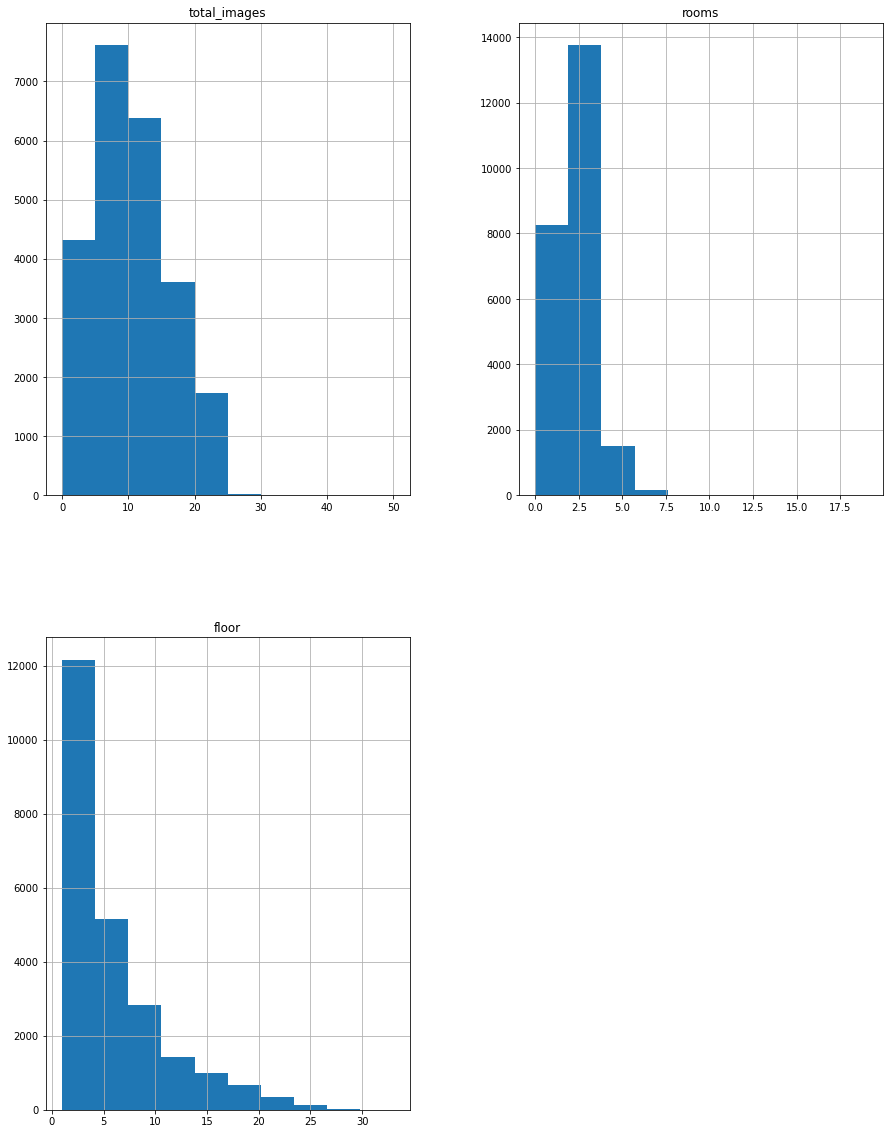

In [3]:
data.hist(figsize=(15, 20));

Комментарий студента:
Из первого блока можно сделать следующие вывода:
1. Всего 23699 строк, 22 столбца;
2. Многие столцбы в формате object, что не даёт методу hist() построить гистограммы;
3. По выведенным гистограммам:
  - Для 'total_images' большинство фотографий в количестве 5-10 штук;
  - Наибольшее число комнат в объявлениях от 2 до 3 включительно;
  - Чаще всего в объявлениях встречаются квартиры с 1 по 4 этаж.

Однако не стоит делать поспешные выводы по гистограммам, так как для начала стоит убедиться в корректности данных.


### Предобработка данных

In [4]:
print(data.isna().sum())
# Количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [6]:
print(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data['is_apartment'].value_counts())
#Стоит предложить, что пользователи просто пропускали момент, когда надо было выбирать является ли их недвижимость апартаментом.

False    2725
True       50
Name: is_apartment, dtype: int64
False    23649
True        50
Name: is_apartment, dtype: int64


In [7]:
print(data['balcony'].value_counts())
data['balcony'] = data['balcony'].fillna(0)
print(data['balcony'].isna().sum())

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64
0


In [8]:
data = data.dropna(subset=['locality_name'])
print(data['locality_name'].isna().sum())
# Пропуск в ['locality_name'] - случайный пропуск. Невозможно восстановить с помощью других значений.
# Пустое поле тоже не является корректным решением.
print(data.isna().sum())
# Для ['airports_nearest'], ['cityCenters_nearest'], ['parks_around3000'], ['parks_nearest'], ['ponds_around3000']
# ['ponds_nearest'], ['days_exposition'] стоит оставить пропуски. 
# Так как это значение нельзя восстановить, а 0 сильно изменит медиан и ср.
# (Да и в целом эти данные не нужны для анализа)
# p.s.
# ['kitchen_area'] и ['living_area'] - для данных пропусков нет однозначного решения.
# Один из вариантов - разбить квартиры по ценовым категориям и заполнить пропуски медианным значением для каждой категории.

0
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64


In [9]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
# заполняем пустые значения нулём, тк в дальнейшем столбец нужен будет для анализа.

In [10]:
data['ceiling_height'] = pd.to_numeric(data['ceiling_height'], errors='raise')
q = data.agg({'ceiling_height': ['mean', 'median']})
print(q)
# Помимо пропусков в данных присутствуют аномальные значения. По снипу минимальная высота потолка равна 2.5м. 
# Стандарта для высотой не существует, поэтому я буду оперировать значением до 6 метров. 
# Пустые значения планирую заполнять стандартом в 2.7м.

        ceiling_height
mean              2.77
median            2.65


In [11]:
print(len(data.query('ceiling_height < 2.5')))
print(len(data.query('ceiling_height > 6')))
# Всего  квартир, где высота меньше 2.5 метров -- 73. На фоне 23699 строк это небольшие значения. Тут есть два способа:
# 1. Удалить эти значения
# 2. Заменить медианным значением.
# Всё-таки высота потолка не является ключевым показателем в выборе квартире. Поэтому для квартир где высота < 2.5м 
# будем менять на стандартную высоту квартир, а именно - 2.7 метра.

73
29


In [12]:
data_ceilingh_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(data_ceilingh_median)
print(data['ceiling_height'].isna().sum())

0


In [13]:
data.loc[data['ceiling_height'] < 2.5, 'ceiling_height'] = data_ceilingh_median
print(len(data.query('ceiling_height < 2.5')))
data.loc[data['ceiling_height'] > 6, 'ceiling_height'] = data_ceilingh_median
print(len(data.query('ceiling_height > 6')))

w = data.agg({'ceiling_height': ['mean', 'median']})
print(w)

0
0
        ceiling_height
mean              2.70
median            2.65


Комментарий студента:
Среднее значение уменьшилось на 0.05, а медиана увеличилась на 0.05
В целом данные не сильно изменились. Учитывая, что пропущенных значений чуть более 9000.

In [14]:
data['last_price'] = pd.to_numeric(data['last_price'])
data['floors_total'] = pd.to_numeric(data['floors_total'])
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'])
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'])
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'])
data['cityCenters_nearest'] = pd.to_numeric(data['cityCenters_nearest'])
data['total_area'] = pd.to_numeric(data['total_area'])
data['living_area'] = pd.to_numeric(data['living_area'])
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])
data['balcony'] = pd.to_numeric(data['balcony'])
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'])
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'])
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'])
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# В некоторых столбцах уже были изменены типы данных(для того чтобы посмотреть как изменится средняя). 
# Несколько столбцов остались в старом формате, из-за отсутствия необходимости при анализе
# При типе данных object невозможно посчитать среднее значение и построить графики. 
# Также метод describe() не работает полноценно.
# (errors=raise - по умолчанию, я для себя прописывал данный параметр)

In [15]:
data.duplicated().sum()
# явных дубликатов в проекте не обнаружено

0

In [16]:
print(data['locality_name'].value_counts())
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')).replace(['городской поселок'], 'поселок городского типа', regex=True).str.replace('ё', 'е').replace(['поселок при железнодорожной станции'], 'поселок станции', regex=True)
data['locality_name'] = data['locality_name'].replace(['село Павлово'], 'поселок городского типа Павлово', regex=True)
data['locality_name'] = data['locality_name'].replace(['садовое товарищество Рахья'], 'поселок городского типа Рахья', regex=True)
data['locality_name'] = data['locality_name'].replace(['поселок Калитино'], 'деревня Калитино', regex=True)
data['locality_name'] = data['locality_name'].replace(['садовое товарищество Приладожский'], 'поселок городского типа Приладожский', regex=True)  
data['locality_name'] = data['locality_name'].replace(['поселок Щеглово'], 'деревня Щеглово', regex=True)
data['locality_name'] = data['locality_name'].replace(['поселок Гарболово'], 'деревня Гарболово', regex=True)
print(data['locality_name'].unique())
print(data['locality_name'].value_counts())
# в этой части были обработаны неявные дубликаты: 
# - 'ё' на 'е'
# - небольшая путанница с 'селом' 'село городского типа' и т.д.
# также были обработаны частные случаи для отдельных локаций.

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
                           ...  
посёлок Сумино                 1
поселок станции Лужайка        1
поселок Красносельское         1
деревня Большой Сабск          1
поселок станции Корнево        1
Name: locality_name, Length: 364, dtype: int64
['Санкт-Петербург' 'поселок Шушары' 'поселок городского типа Янино-1'
 'поселок Парголово' 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'деревня Федоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'деревня Новое Девяткино'
 'поселок Металлострой' 'поселок городского типа Лебяжье'
 'поселок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск'

**<font color="skyblue">Промежуточный вывод.<font>**
    
В первом этапе проекта была изучена первичная информация и обработаны данные с помощью методов isna(), fillna(), replace() и to_numeric. Всего в коде 23699 строк и 22 столбца, описывающие статистику по продажам квартир на территории Ленинградской области. 
    
В данных присутствуют пропуски. Некоторые из них можно заполнить медианным значением, некоторые нулями, а некоторые остались без изменений, так как нет достоверного способа заполнить пропуски.
    
Также были выведены первичные графики с помощью метода hist(), но большинство столбцов были в другом типе данных, что не позволило полностью проанализировать информацию.

### Посчитайте и добавьте в таблицу новые столбцы

In [17]:
data['1m^2_price'] = data['last_price'] / data['total_area']
# столбец с ценами за один квадратный метр

In [18]:
# data['first_day_exposition'].hist(figsize=(15, 20))
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1H')
# Округляем значения
data['weekday'] = data['first_day_exposition'].dt.weekday
# print(data.isna().sum())
# столбец "день публикации объявления (0 - понедельник, 1 - вторник и т.д.)"

In [19]:
data['month'] = data['first_day_exposition'].dt.month
# print(data['month'].value_counts())

In [20]:
data['year'] = data['first_day_exposition'].dt.year
# print(data['year'].value_counts())

In [21]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)
data['floor_type'].value_counts()

другой       17408
последний     3330
первый        2912
Name: floor_type, dtype: int64

In [22]:
# print(data.isna().sum())
data['distance_km'] = round(data['cityCenters_nearest'] / 1000, 0)

#### P.S.
Изначально проект выглядел по-другому. Здесь я решил объединить задание 'устранены редкие и выбивающиеся значения (аномалии) во всех столбцах' и 'изучены и описаны следующие параметры:', чтобы код выглядел лаконичнее

In [23]:
def qwe(asd):
    return asd.describe()

count   23650.00
mean        9.86
std         5.68
min         0.00
25%         6.00
50%         9.00
75%        14.00
max        50.00
Name: total_images, dtype: float64


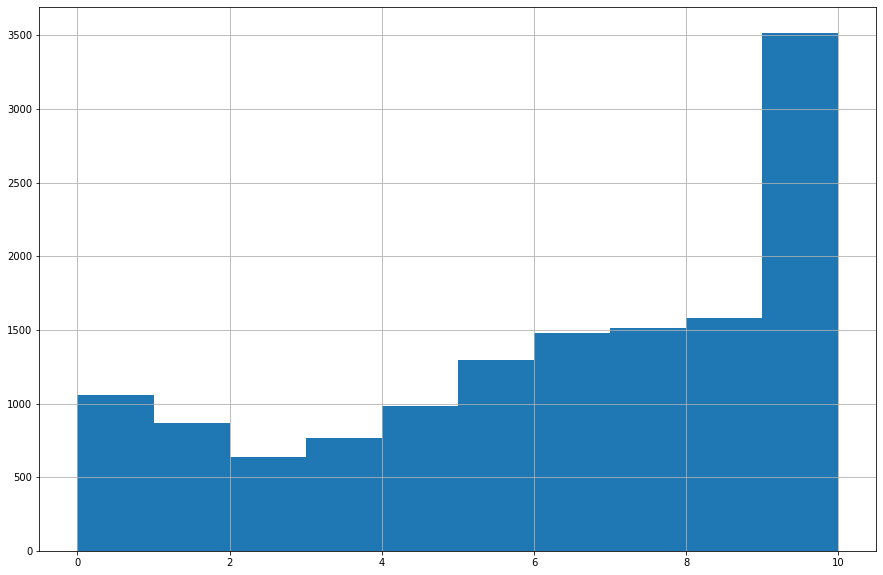

In [24]:
data['total_images'].hist(figsize=(15, 10), range=(0,10));
print(qwe(data['total_images']))
# БОльшая часть приходится от 0 до 25 фотографий.

count       23649.00
mean      6541402.97
std      10896546.84
min        430000.00
25%       3400000.00
50%       4650000.00
75%       6799000.00
max     763000000.00
Name: last_price, dtype: float64


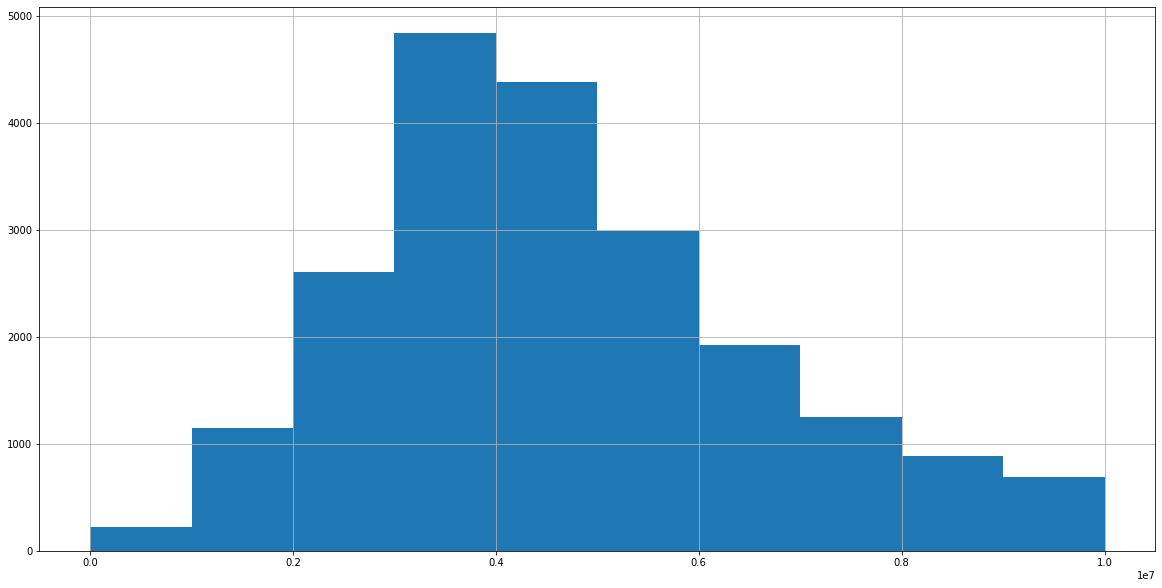

In [25]:
data['last_price'].hist(figsize=(20, 10), range=(0,10000000));
# data['last_price'].hist(figsize=(20, 10), range=(0,1000000))
# print(data.sort_values(by='last_price', ascending=False))
data = data.drop(labels=[8793],axis = 0).reset_index()
print(qwe(data['last_price']))
# аномальная сумма

count   23649.00
mean       60.33
std        35.66
min        12.00
25%        40.00
50%        52.00
75%        69.70
max       900.00
Name: total_area, dtype: float64
       index  total_images   last_price  total_area first_day_exposition  \
19504  19540             8 420000000.00      900.00           2017-12-06   

       rooms  ceiling_height  floors_total  living_area  floor  ...  \
19504     12            2.80         25.00       409.70     25  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
19504            NaN              2.00         318.00            106.0   

       1m^2_price weekday  month  year  floor_type  distance_km  
19504   466666.67       2     12  2017   последний         8.00  

[1 rows x 29 columns]


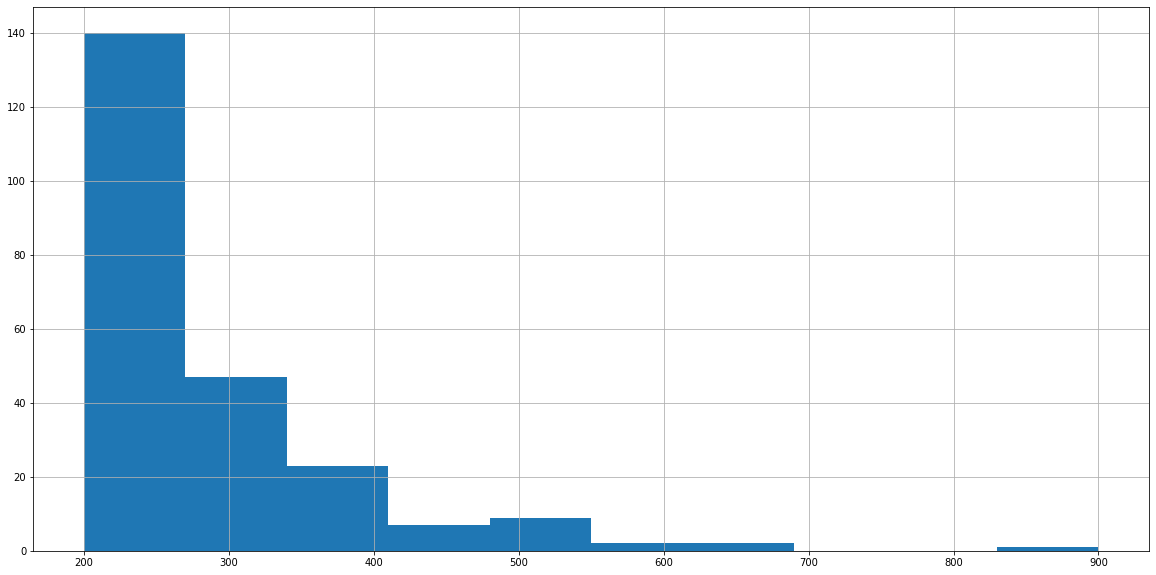

In [26]:
data['total_area'].hist(figsize=(20, 10), range=(200,900));
print(qwe(data['total_area']))
print(data[data['total_area'] == 900]) 
# аномалий в данном объекте недвижимости не обнаружено, около нулевых значений не обнаружено.
# Могут ли быть квартиры более 250 квадратным метра? Вполне. 

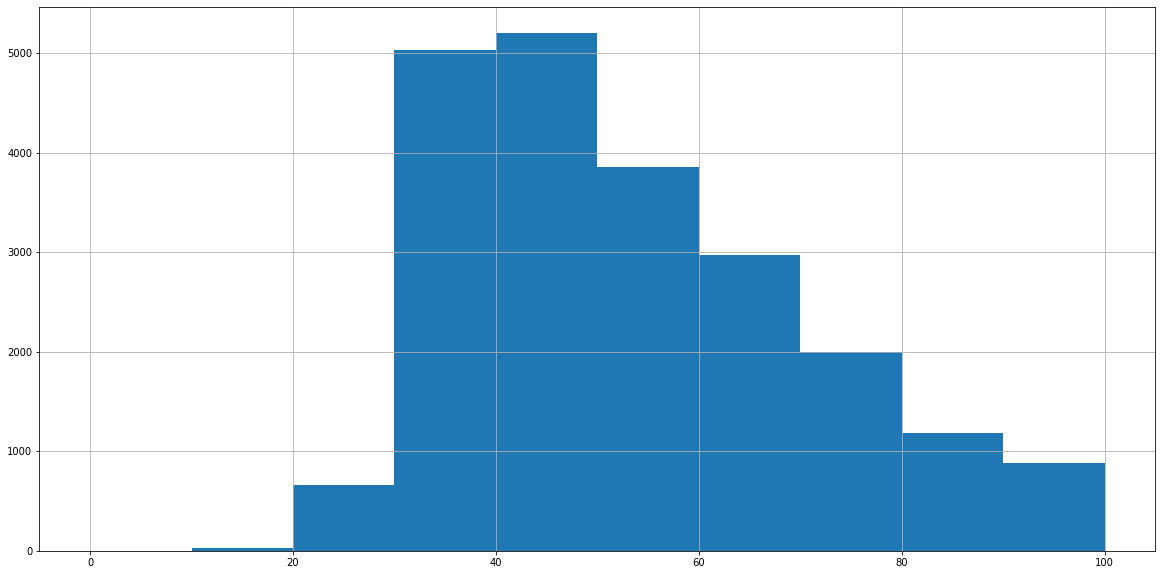

In [27]:
data['total_area'].hist(figsize=(20, 10), range=(0,100));
data = data.loc[data['total_area'] >= 20]
# Аномальных пиков тоже не обнаружено.

count   21376.00
mean       10.57
std         5.90
min         1.30
25%         7.00
50%         9.10
75%        12.00
max       112.00
Name: kitchen_area, dtype: float64


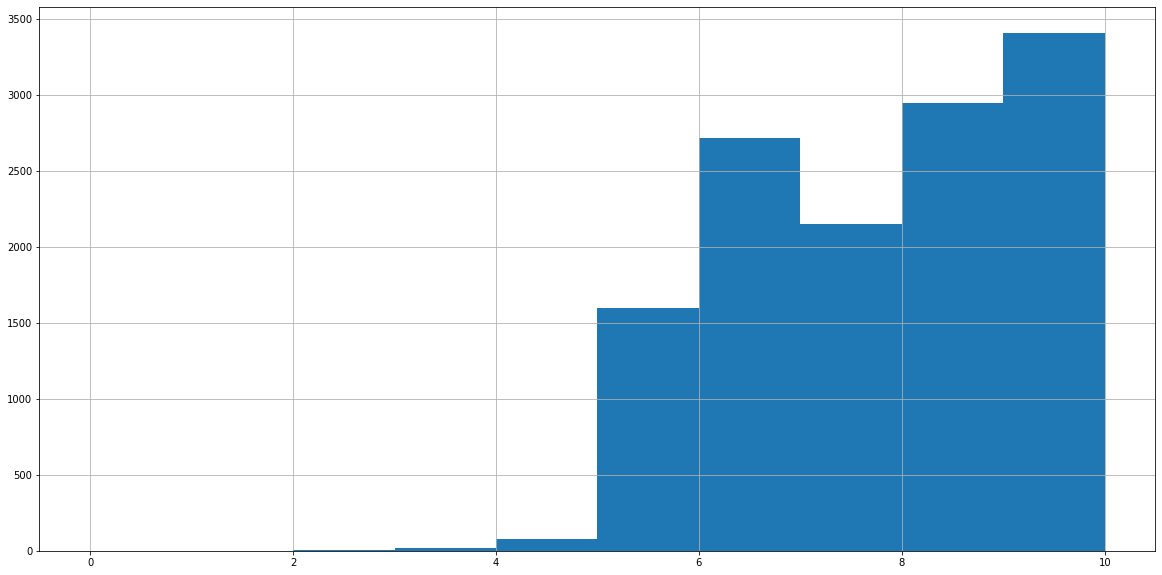

In [28]:
print(qwe(data['kitchen_area']))
data['kitchen_area'].hist(figsize=(20, 10), range=(0,10));

In [29]:
# data = data.loc[data['kitchen_area'] >= 3]
# Удалил строки с квартирами с площадью кухни меньше, чем 3 квадратных метра. Таких квартир < 50 штук
# что не сильно отразится на данных

count   21733.00
mean       34.47
std        22.04
min         2.00
25%        18.60
50%        30.00
75%        42.30
max       409.70
Name: living_area, dtype: float64


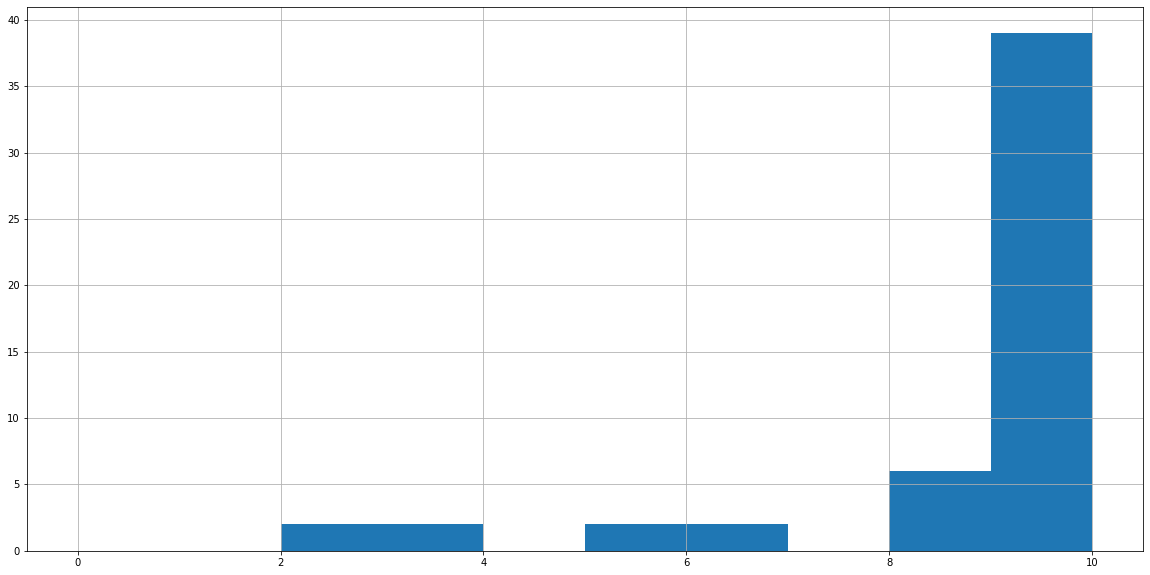

In [30]:
print(qwe(data['living_area']))
data['living_area'].hist(figsize=(20, 10),range=(0,10));

count   23622.00
mean        2.07
std         1.08
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64


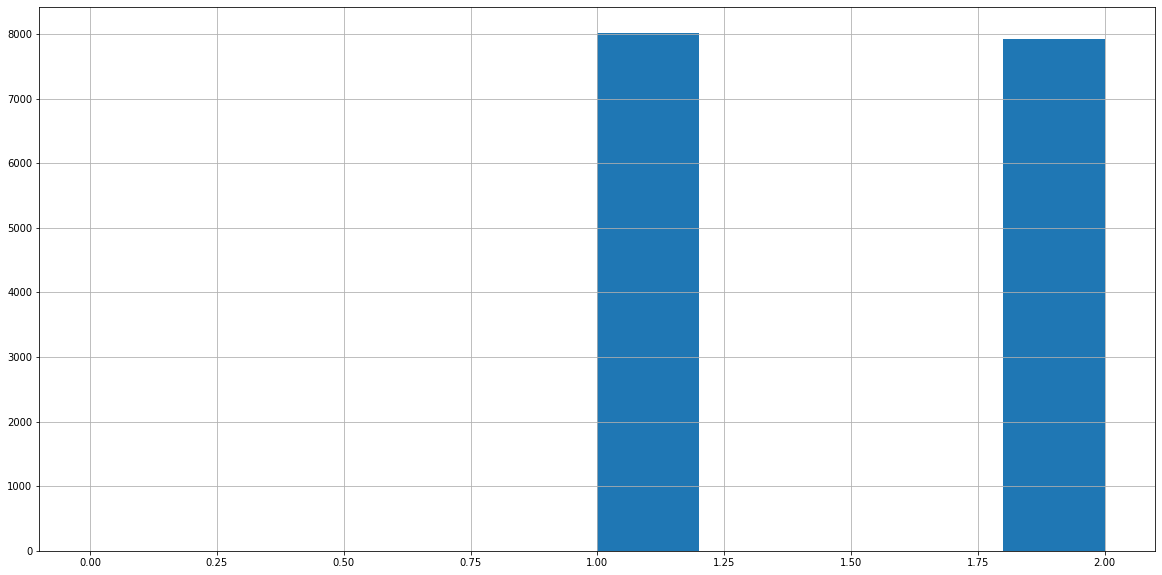

In [32]:
print(qwe(data['rooms']))
#data['rooms'].hist(figsize=(20, 10),range=(5,20))
data = data.loc[data['rooms'] > 0]
data['rooms'].hist(figsize=(20, 10),range=(0,2));
# 0 комнат в квартире - аномальное значение.            

count   23433.00
mean        2.70
std         0.22
min         2.50
25%         2.60
50%         2.65
75%         2.70
max         6.00
Name: ceiling_height, dtype: float64


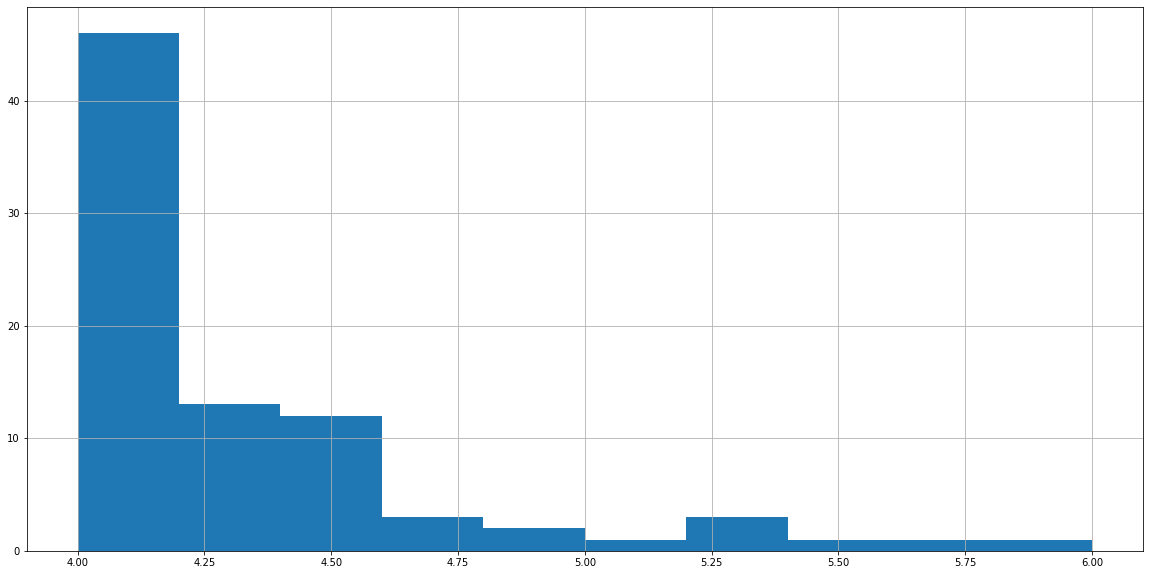

In [33]:
print(qwe(data['ceiling_height']))
data['ceiling_height'].hist(figsize=(20, 10), range=(4,6));
# аномалий не обнаружено.

count   23433.00
mean        5.87
std         4.86
min         1.00
25%         2.00
50%         4.00
75%         8.00
max        33.00
Name: floor, dtype: float64


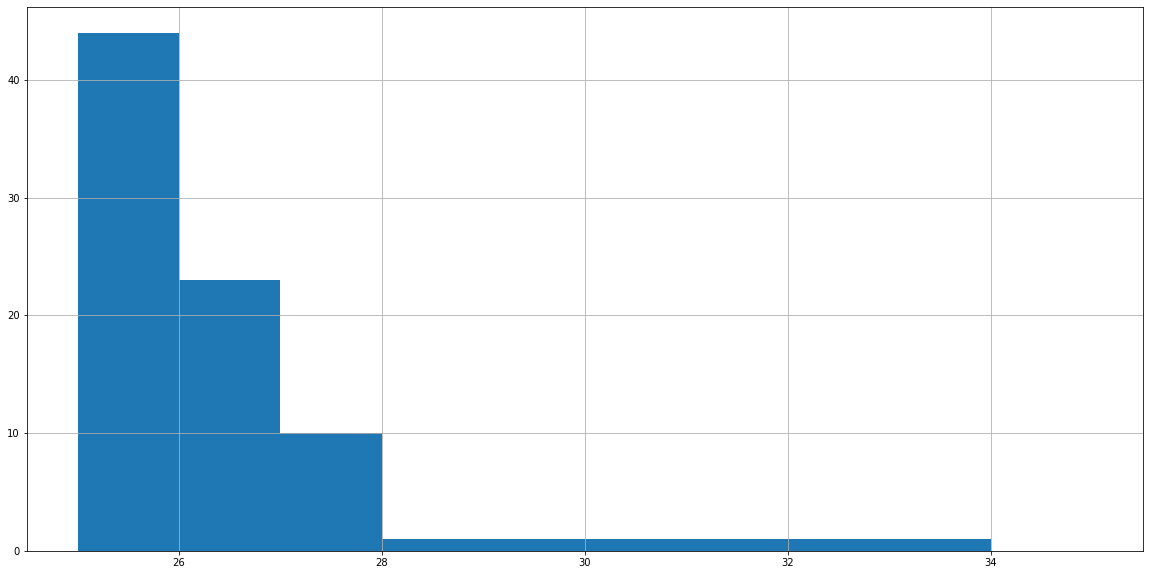

In [34]:
print(qwe(data['floor']))
data['floor'].hist(figsize=(20, 10), range=(25,35));
# аномалий не обнаружено.

count   23351.00
mean       10.63
std         6.57
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64


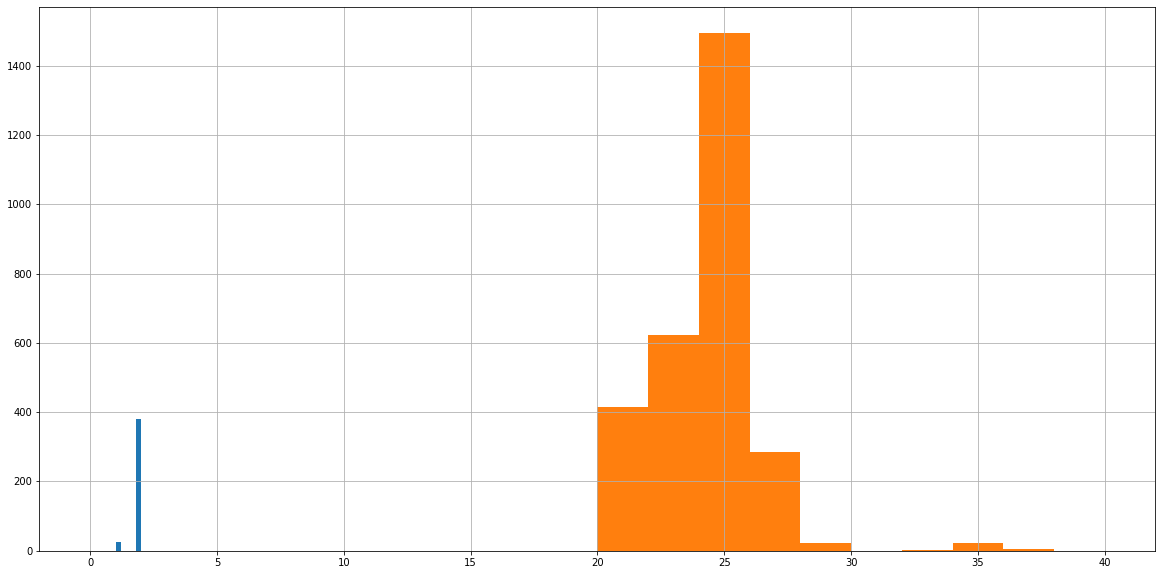

In [35]:
print(qwe(data['floors_total']))
data['floors_total'].hist(figsize=(20, 10), range=(0,2));
data['floors_total'].hist(figsize=(20, 10), range=(20, 40));
# аномалий не обнаружено.

другой       17232
последний     3315
первый        2886
Name: floor_type, dtype: int64

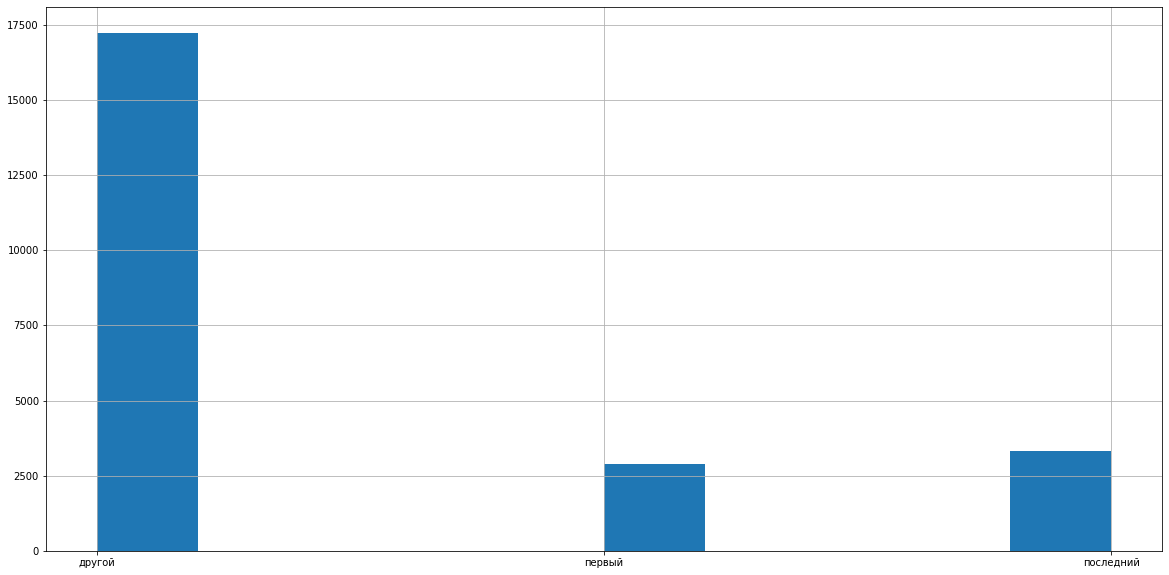

In [36]:
data['floor_type'].hist(figsize=(20, 10));
data['floor_type'].value_counts()
# аномалий не обнаружено.

In [37]:
print(qwe(data['balcony']))

count   23433.00
mean        0.59
std         0.96
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         5.00
Name: balcony, dtype: float64


count   17983.00
mean    28835.05
std     12635.91
min         0.00
25%     18590.00
50%     26773.00
75%     37317.50
max     84869.00
Name: airports_nearest, dtype: float64


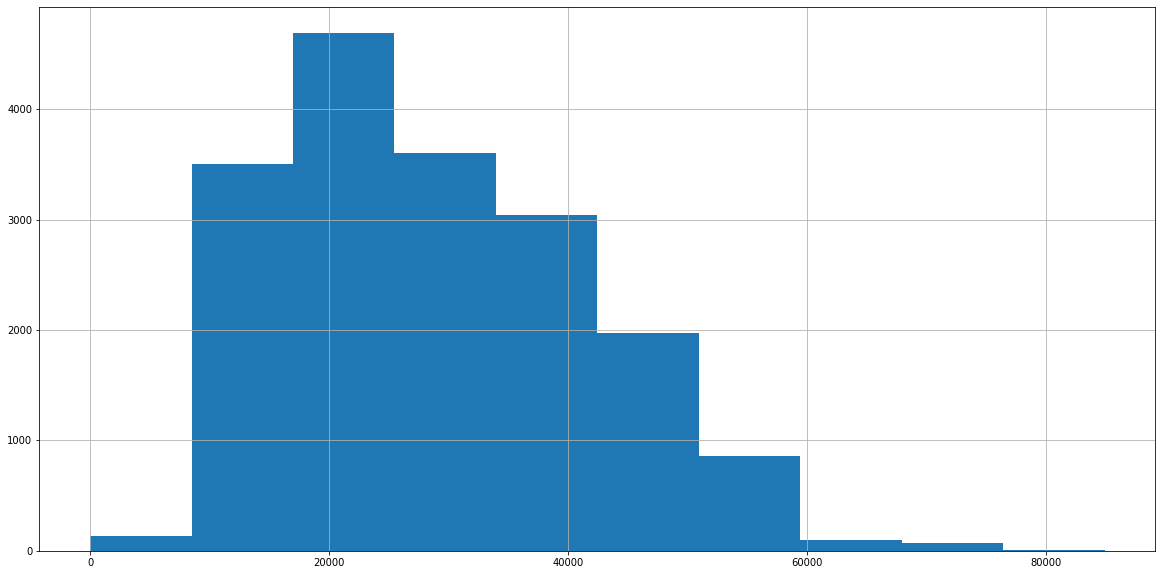

In [38]:
print(qwe(data['airports_nearest']))
data['airports_nearest'].value_counts()
data['airports_nearest'].hist(figsize=(20, 10));
# Нулевые значения скорее всего указывают на то, что данные некорректны, но удалять их не будем.

count   23433.00
mean    10916.77
std      9647.93
min         0.00
25%      2323.00
50%     11269.00
75%     15255.00
max     65968.00
Name: cityCenters_nearest, dtype: float64


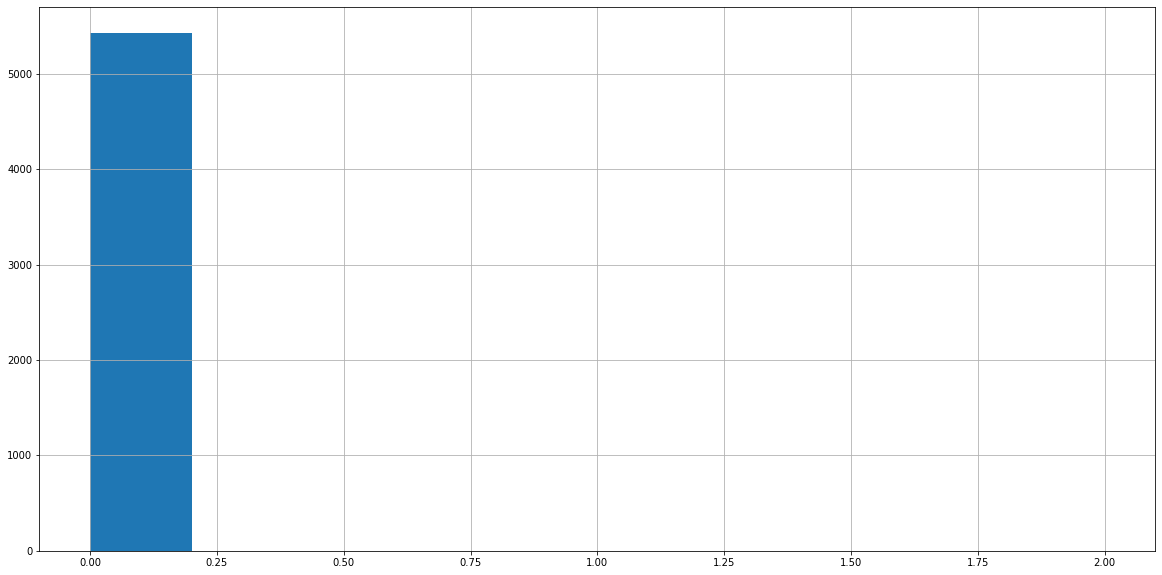

In [39]:
data['cityCenters_nearest'].hist(figsize=(20, 10),range=(0,2));
data['cityCenters_nearest'].value_counts()
print(qwe(data['cityCenters_nearest']))
# У большинства объектов не указана расстояние до центра.

In [40]:
print(data['parks_around3000'].value_counts())
print(qwe(data['parks_around3000']))
# Столб описывает парки в радиусе 3км 4-мя значениями:
# 1км
# 2км
# 3км
# И нулевым значениям. Стоит предположить, что все пропуски и значения 0 имеют одинаковую ценность, а именно, что для этих
# объектов недвижимости не предусмотрен парк в радиусе 3км. Либо пользователи отказались заполнять данный параметр.

0.00    9983
1.00    5643
2.00    1736
3.00     645
Name: parks_around3000, dtype: int64
count   18007.00
mean        0.61
std         0.80
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         3.00
Name: parks_around3000, dtype: float64


count   8028.00
mean     490.39
std      342.73
min        1.00
25%      287.00
50%      453.00
75%      612.00
max     3190.00
Name: parks_nearest, dtype: float64


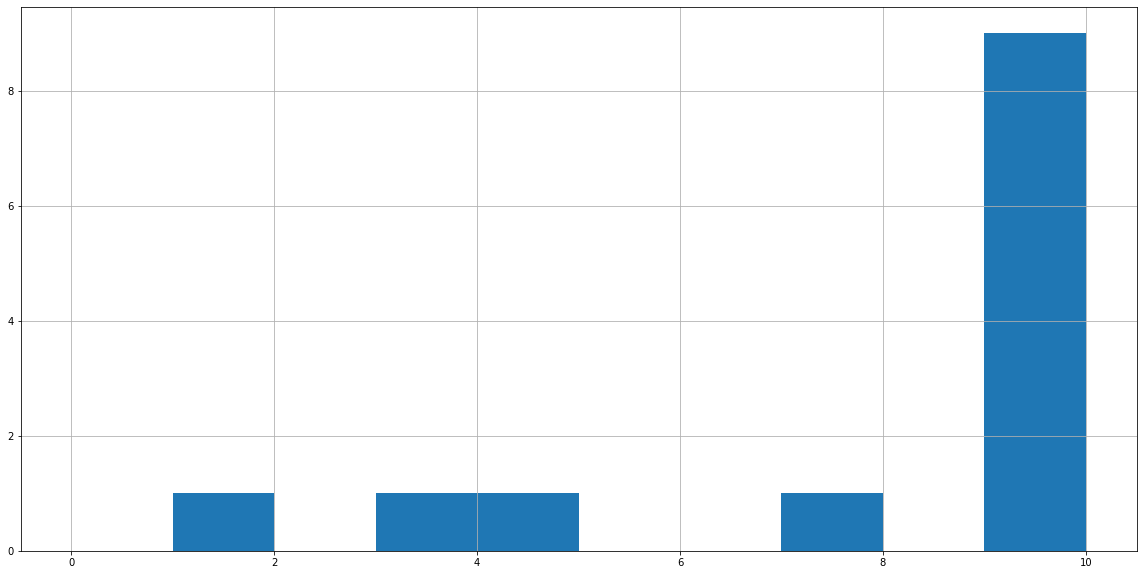

In [41]:
print(qwe(data['parks_nearest']))
data['parks_nearest'].value_counts()
data['parks_nearest'].hist(figsize=(20, 10), range=(0,10));
# аномалий не обнаружено.

In [42]:
print(qwe(data['ponds_around3000']))
print(data['ponds_around3000'].value_counts())
# аналогично выводу в ['parks_around3000']

count   18007.00
mean        0.77
std         0.94
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         3.00
Name: ponds_around3000, dtype: float64
0.00    9000
1.00    5646
2.00    1876
3.00    1485
Name: ponds_around3000, dtype: int64


In [43]:
print(qwe(data['ponds_nearest']))

count   9007.00
mean     518.14
std      277.74
min       13.00
25%      293.50
50%      502.00
75%      730.00
max     1344.00
Name: ponds_nearest, dtype: float64


3    4246
1    4138
4    3942
2    3930
0    3580
5    1921
6    1676
Name: weekday, dtype: int64


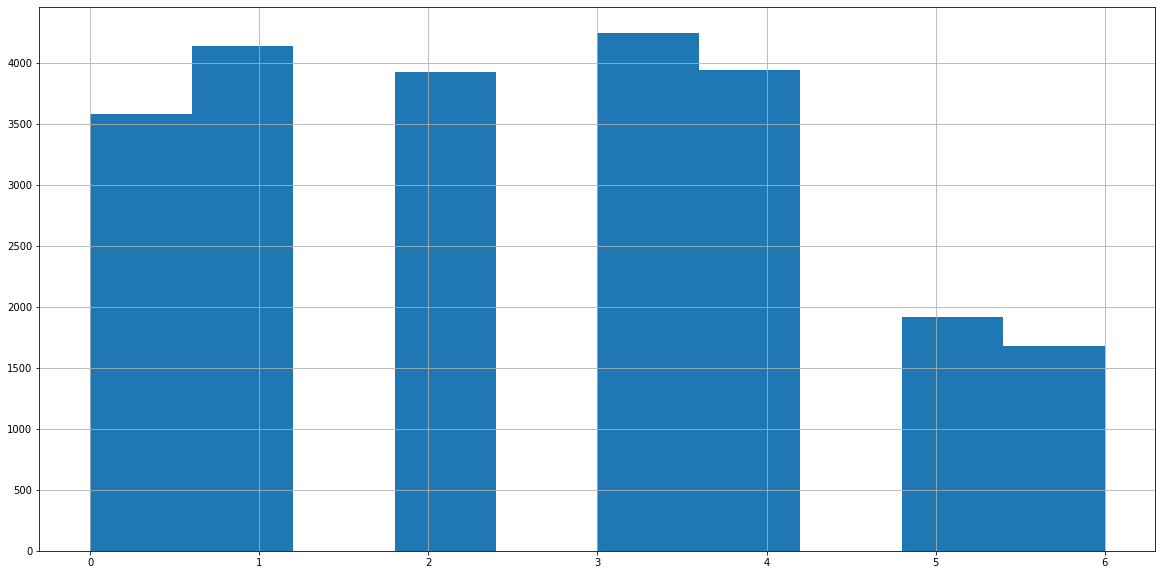

In [44]:
print(data['weekday'].value_counts())
data['weekday'].hist(figsize=(20, 10));
# В будние дни чаще всего выкладывали объявления. В выходные происходит резкий спад количества объявлений.

2     2621
3     2561
4     2358
11    2334
10    2107
9     1955
6     1750
8     1718
7     1670
12    1620
1     1477
5     1262
Name: month, dtype: int64


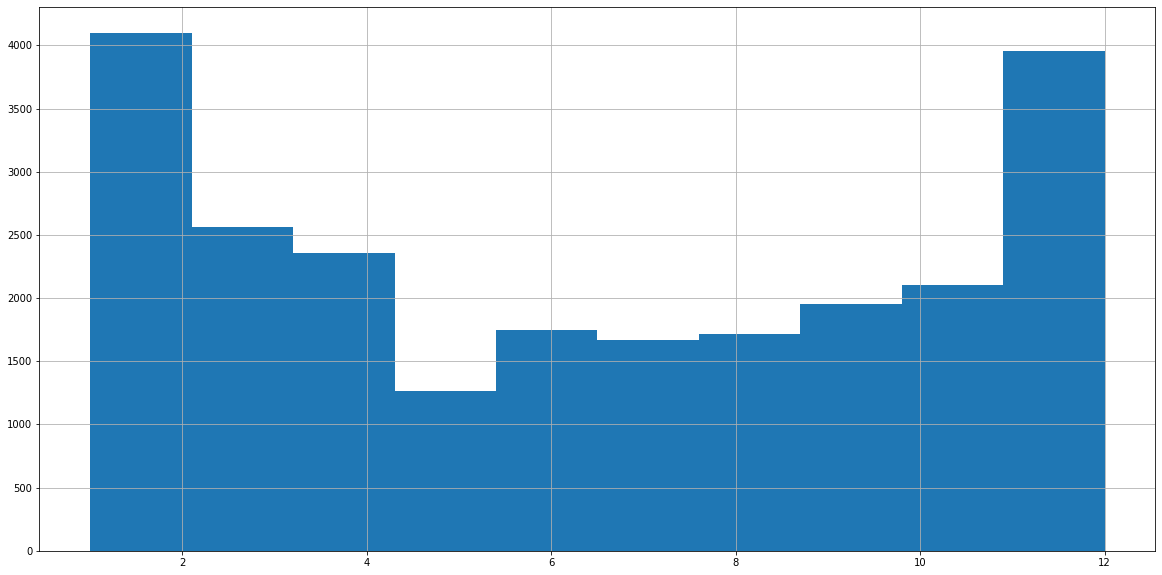

In [45]:
print(data['month'].value_counts());
data['month'].hist(figsize=(20, 10));
# Можно сделать выводы, что продажа/покупка происходит в начале/в конце года. Середина года - наибольший спад.

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23433 entries, 0 to 23648
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 23433 non-null  int64         
 1   total_images          23433 non-null  int64         
 2   last_price            23433 non-null  float64       
 3   total_area            23433 non-null  float64       
 4   first_day_exposition  23433 non-null  datetime64[ns]
 5   rooms                 23433 non-null  int64         
 6   ceiling_height        23433 non-null  float64       
 7   floors_total          23351 non-null  float64       
 8   living_area           21557 non-null  float64       
 9   floor                 23433 non-null  int64         
 10  is_apartment          23433 non-null  bool          
 11  studio                23433 non-null  bool          
 12  open_plan             23433 non-null  bool          
 13  kitchen_area    

**<font color="skyblue">Промежуточный вывод.<font>**

Во втором этапе были рассмотрены и изучены столбцы, а также созданы новые (цена за один квадратный метр, расстояние до центра города и созданы более подробные столбцы с датой и временем).
    
С помощью метода hist() были созданы графики ко всем возможным параметрам, изучаны и обработаны аномальные значения. После данного этапа информация из проекта готова для дальнейшего исследовательского анализа.

### Проведите исследовательский анализ данных

count   20267.00
mean      181.48
std       220.18
min         1.00
25%        45.00
50%        96.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64


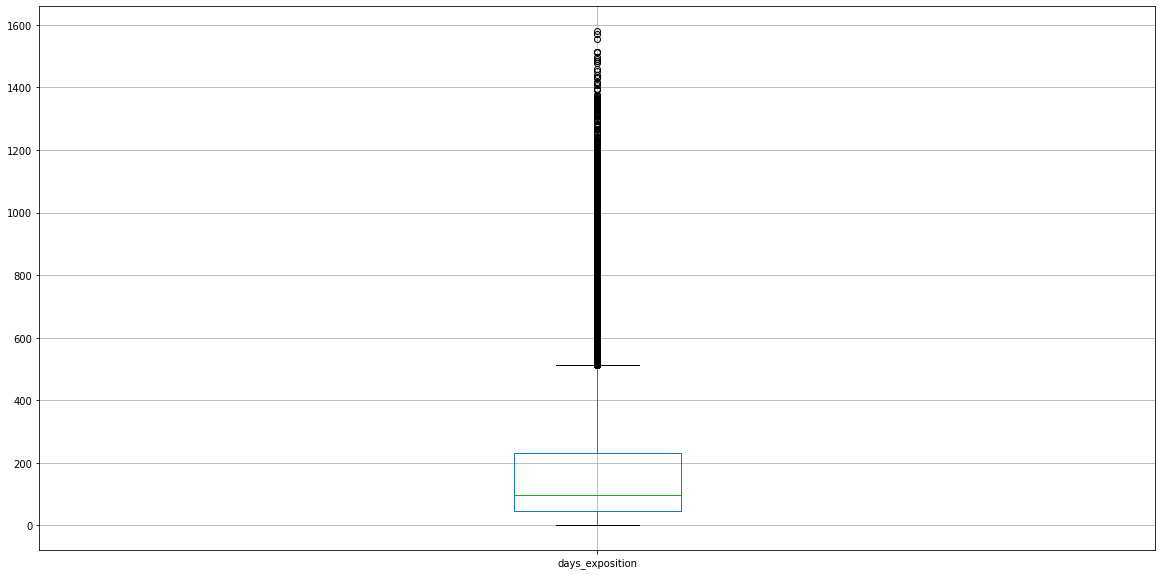

In [47]:
data['days_exposition'] = pd.to_numeric(data['days_exposition'])
data.boxplot('days_exposition',figsize=(20, 10))
print(qwe(data['days_exposition']))

In [1]:
data['days_exposition'].hist(figsize=(12, 7),bins=50, range=(0,96));

NameError: name 'data' is not defined

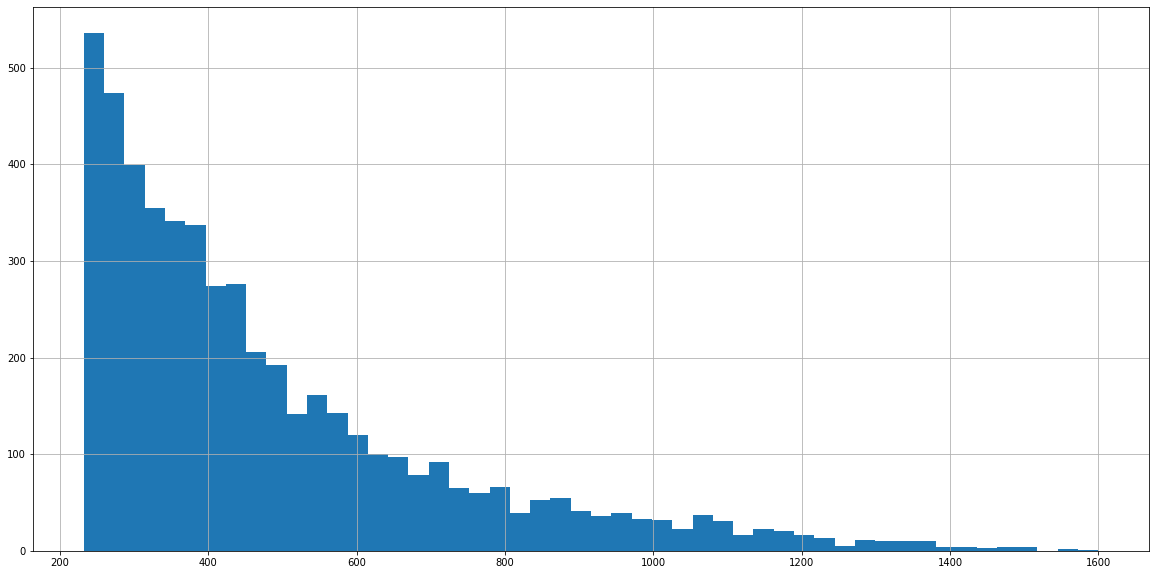

In [49]:
data['days_exposition'].hist(figsize=(20, 10),bins=50, range=(232, 1600));

**<font color="green">Комментарий студента:<font>**
Немного изменил подход. Сам график рассмотрим поподробнее и помимо метода describe() используем метод boxplot(), чтобы рассмотреть данные на различных участках внимательнее. Можно выделить пики в 45 и 60 день+-.

По поводу подозрительных пиков... У нашей когорты есть тг-канал, когда-то неспециально я увидел рассуждение ребят... Пришли к выводу, что это дни когда публикация уходит в архив/инактив, если её не продлит пользователь. (Неловко получилось... но это не значит, что суждение правдиво. Просто сам склоняюсь к данному варианту)

Продажа по медианному значению занимает - 96 дней, по среднему - 181, что намного больше. 
Наглядно видно как влияют нестандартные значения на среднюю.

Минимальное и максимальное значение - 1 и 1580.

В целом квартиры, которые продавались меньше чем за 45 дней можно назвать быстрыми.
А те, которые продаются больше чем 10 месяцев - долгими. Квартиры, которые продаются больше 600 дней - необычно долгими.

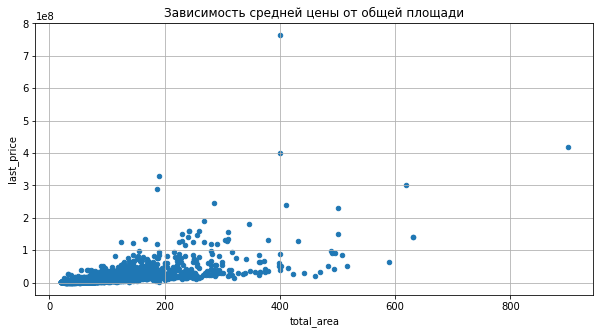

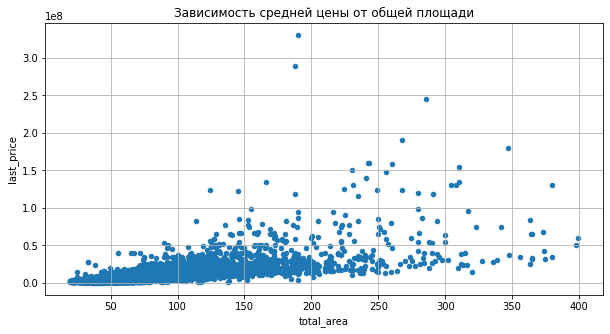

In [50]:
data.plot(x='total_area', y='last_price',\
title='Зависимость средней цены от общей площади', figsize=(10,5),grid=True, kind='scatter');
data_lastprice = data[data['total_area'] < 400]
data_lastprice.plot(x='total_area', y='last_price',\
title='Зависимость средней цены от общей площади', figsize=(10,5), grid=True, kind='scatter');

На графике зависимости цены от общей площади видна тенденция к увелечению цены за бОльшую площадь. На графике присутствуют пики, рассмотрим несколько объектов:

In [51]:
display(data.query('total_area > 150 and total_area < 200 and last_price > 250000000'))

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m^2_price,weekday,month,year,floor_type,distance_km
1435,1436,19,330000000.00,190.00,2018-04-04,3,3.50,7.00,95.00,5,...,519.00,3.00,285.00,233.00,1736842.11,2,4,2018,другой,1.00
22783,22831,18,289238400.00,187.50,2019-03-19,2,3.37,6.00,63.70,6,...,386.00,3.00,188.00,NaN,1542604.80,1,3,2019,последний,1.00


Причиной высокой цены данных квартир является их непосредственная близость к центру городу.


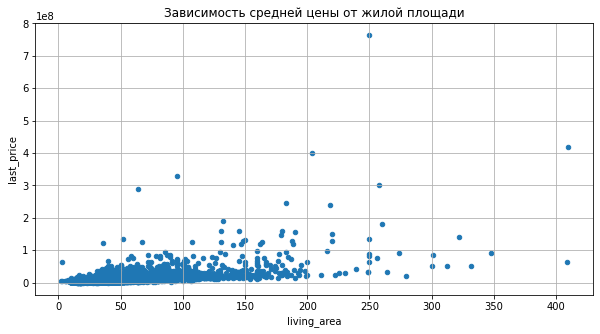

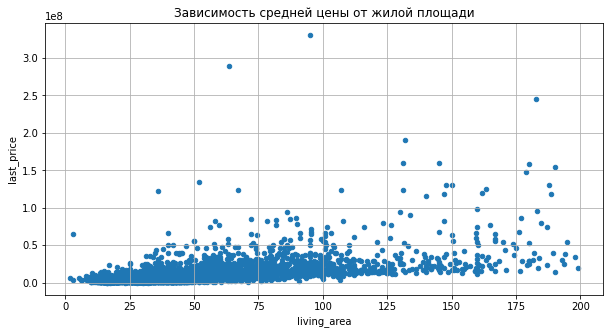

In [52]:
data.plot(x='living_area', y='last_price',\
title='Зависимость средней цены от жилой площади', figsize=(10,5),grid=True, kind='scatter');
data_lastpriceliv = data[data['living_area'] < 200]
data_lastpriceliv.plot(x='living_area', y='last_price',\
title='Зависимость средней цены от жилой площади', figsize=(10,5), grid=True, kind='scatter');

На графике зависимости цены от жилой площади также видна тенденция к увелечению цены за бОльшую площадь. На графике присутствуют пики, рассмотрим один из них:

In [53]:
display(data.query('living_area < 15 and last_price > 500000 and last_price < 1000000'))

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m^2_price,weekday,month,year,floor_type,distance_km
9454,9471,4,850000.00,78.00,2017-05-04,3,2.65,9.00,12.50,7,...,NaN,NaN,NaN,169.00,10897.44,3,5,2017,другой,0.00


**<font color="green">Комментарий студента:<font>**
    
Данный объект выглядит аномальным. Значит при поиске аномальных данных в прошлом этапе проектной работы стоило 'обрубить' такие квартиры. (Не сделано, потому что терялись данные с NaN).

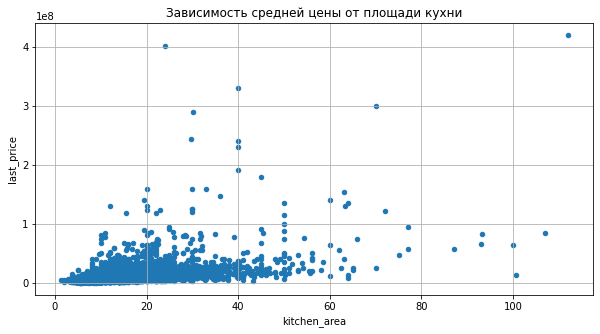

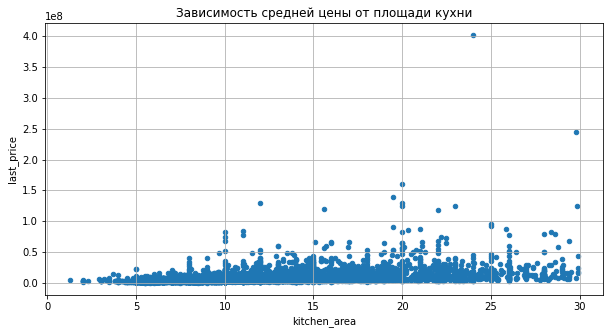

In [54]:
data.plot(x='kitchen_area', y='last_price',\
title='Зависимость средней цены от площади кухни', figsize=(10,5),grid=True, kind='scatter');
data_lastpricekit = data[data['kitchen_area'] < 30]
data_lastpricekit.plot(x='kitchen_area', y='last_price',\
title='Зависимость средней цены от площади кухни', figsize=(10,5), grid=True, kind='scatter');

На графике зависимости цены от площади кухни также видна тенденция к увелечению цены за бОльшую площадь. На графике присутствуют пики, рассмотрим один из них:

In [55]:
display(data.query('kitchen_area < 25 and last_price > 350000000'))

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m^2_price,weekday,month,year,floor_type,distance_km
14680,14706,15,401300000.00,401.00,2016-02-20,5,2.65,9.00,204.00,9,...,545.00,1.00,478.00,393.00,1000748.13,5,2,2016,последний,2.00


Ничего аномального в данном объекте нет. Можно предположить, что маленькая площадь кухни связаны с тем как распланирована сама квартира. Учитывая, что квартира находится в 2 км от центра... цена - обоснована.

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m^2_price,weekday,month,year,floor_type,distance_km
19504,19540,8,420000000.00,900.00,2017-12-06,12,2.80,25.00,409.70,25,...,NaN,2.00,318.00,106.00,466666.67,2,12,2017,последний,8.00


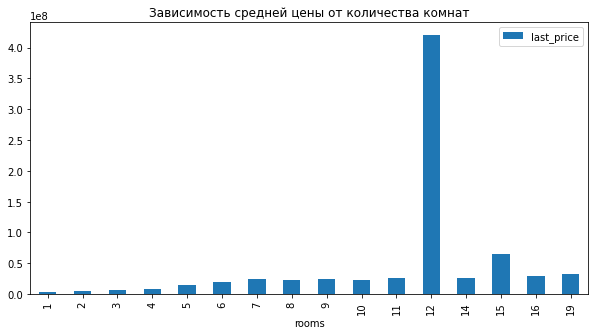

In [56]:
data.pivot_table(index='rooms', values='last_price', aggfunc=('median'))\
.plot(style='bar',title='Зависимость средней цены от количества комнат', figsize=(10,5), kind='bar');
display(data[data['rooms'] == 12])


Пик из-за того, что объектов с 12 комнатами только одна квартира.

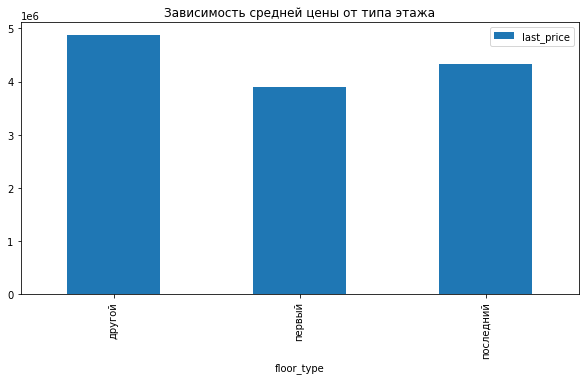

In [57]:
data.pivot_table(index='floor_type', values='last_price', aggfunc=('median'))\
.plot(style='bar',title='Зависимость средней цены от типа этажа', figsize=(10,5), kind='bar');
# первый самый невостребованный. Но огромная часть квартир с типом этажа 'другой', что не даёт правильно проанализировать данные
# из-за слишком большой разности этажей, даже в 10 этажном здании.

Первый самый невостребованный. Но огромная часть квартир с типом этажа 'другой', что не даёт правильно проанализировать данные из-за слишком большой разности этажей, даже в 10 этажном здании.

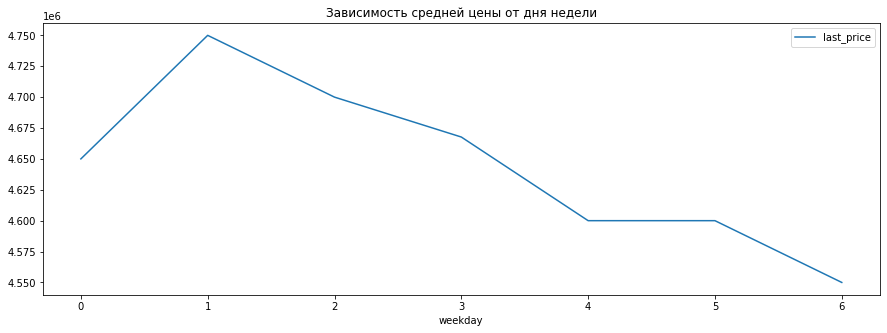

In [58]:
data.pivot_table(index='weekday', values='last_price', aggfunc=('median'))\
.plot(title='Зависимость средней цены от дня недели', figsize=(15,5));

Начало недели - самая активная и самая 'богатая'.

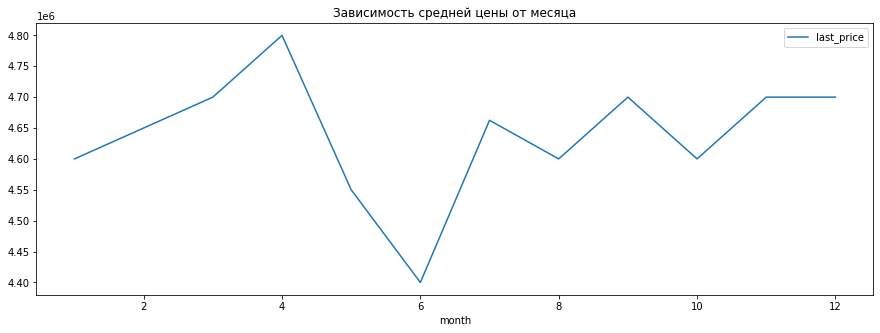

In [59]:
data.pivot_table(index='month', values='last_price', aggfunc=('median'))\
.plot(title='Зависимость средней цены от месяца', figsize=(15,5));

Пик приходится на апрель, около 10 месяцев похожая цена, спад происходит в середине года.

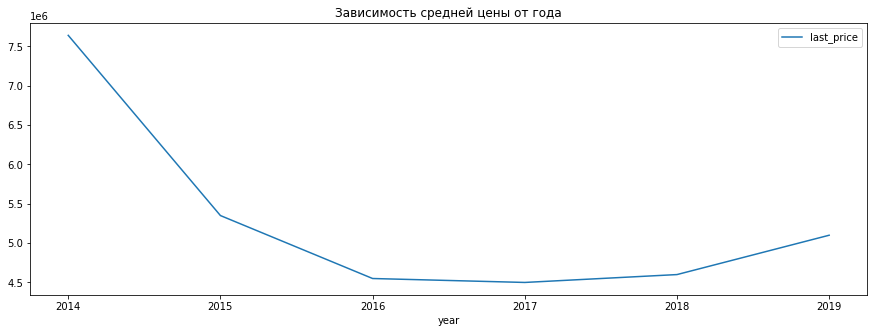

In [60]:
data.pivot_table(index='year', values='last_price', aggfunc=('median'))\
.plot(title='Зависимость средней цены от года', figsize=(15,5));


Здесь стоило бы обратить внимание на количество продаж в каждом году. Так как учитывая инфляцию и программы поддержки строительства, цены должны по логике увеличиваться. Дело может  быть в небольшом количестве продаж в 2014 году.

<font color="blue">Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [61]:
display(data['locality_name'].value_counts().head(10))

Санкт-Петербург      15597
поселок Мурино         529
поселок Шушары         436
Всеволожск             392
Пушкин                 368
Колпино                338
поселок Парголово      323
Гатчина                307
деревня Кудрово        283
Выборг                 237
Name: locality_name, dtype: int64

In [62]:
def mean(city):
    dopdop = data[data['locality_name'] == city]
    return dopdop['1m^2_price'].mean()
print('Средняя цена за квадратный метр в СПБ:', round(mean('Санкт-Петербург'),2))
print()
print('Средняя цена за квадратный метр в Мурино:',round(mean('поселок Мурино'),2))
print()
print('Средняя цена за квадратный метр в Шушары:',round(mean('поселок Шушары'),2))
print()
print('Средняя цена за квадратный метр в Всеволожске:',round(mean('Всеволожск'),2))
print()
print('Средняя цена за квадратный метр в Пушкине:',round(mean('Пушкин'),2))
print()
print('Средняя цена за квадратный метр в Колпино:',round(mean('Колпино'),2))
print()
print('Средняя цена за квадратный метр в Парголово:',round(mean('поселок Парголово'),2))
print()
print('Средняя цена за квадратный метр в Гатчина:',round(mean('Гатчина'),2))
print()
print('Средняя цена за квадратный метр в Кудрово:',round(mean('деревня Кудрово'), 2))
print()
print('Средняя цена за квадратный метр в Выборге:',round(mean('Выборг'),2))
print()
# Можно ли как-то компактнее делать перенос строки? По заданию надо было найти среднее значение, поэтому не использовал медиану.

Средняя цена за квадратный метр в СПБ: 114770.91

Средняя цена за квадратный метр в Мурино: 85004.06

Средняя цена за квадратный метр в Шушары: 78405.74

Средняя цена за квадратный метр в Всеволожске: 68618.01

Средняя цена за квадратный метр в Пушкине: 103081.15

Средняя цена за квадратный метр в Колпино: 75424.58

Средняя цена за квадратный метр в Парголово: 90289.78

Средняя цена за квадратный метр в Гатчина: 68746.15

Средняя цена за квадратный метр в Кудрово: 92297.22

Средняя цена за квадратный метр в Выборге: 58141.91



In [63]:
data_mean_price = [
    ['СПБ', 114849.01],
    ['Мурино', 85681.76],
    ['Шушары', 78677.36],
    ['Всеволожск', 68654.47],
    ['Пушкин', 103125.82],
    ['Колпино', 75424.58],
    ['Парголово', 90175.91],
    ['Гатчина', 68746.15],
    ['Кудрово', 92473.55],
    ['Выборг', 58141.91],
]
columns = ['Название насёленного пункта', 'Цена за один квадратный метр']
data_mpDF = pd.DataFrame(data=data_mean_price, columns=columns)
display(data_mpDF.sort_values(by='Цена за один квадратный метр', ascending=False))

,Название насёленного пункта,Цена за один квадратный метр
0,СПБ,114849.01
4,Пушкин,103125.82
8,Кудрово,92473.55
6,Парголово,90175.91
1,Мурино,85681.76
2,Шушары,78677.36
5,Колпино,75424.58
7,Гатчина,68746.15
3,Всеволожск,68654.47
9,Выборг,58141.91


В Санкт-Петербурге и Пушкине - самые дорогая цена за квадратный метр квартиры. 

In [64]:
data_saint = data[data['locality_name'] == 'Санкт-Петербург']
data_saunt_ww =  data_saint.pivot_table(index='distance_km', values='1m^2_price', aggfunc=('median'))

In [65]:
data_saunt_ww.sort_values(by='1m^2_price', ascending=False)

,1m^2_price
distance_km,
0.00,137050.20
27.00,132115.71
6.00,131835.23
1.00,128398.79
7.00,127017.08
5.00,126932.47
8.00,122619.05
2.00,122047.24
4.00,117952.26


Ошибку исправил.

Есть тенденция по увеличению цены за каждый километр, который ближе к центру. Однако есть нелогичные на первый взгляд цены. Их можно растолковать вот так:
- количество объектов в каждом недвижимости разная.
- более элитные квартиры или ЖК вполне могут быть расположены вдали от центра города.

### Общий вывод

За небольшое время обучения данный проект дал понять несколько вещей, а именно:
- возможность использовать большое количество инструментов для анализа данных;

(К одному выводу можно прийти несколькими способами в python'е с помощью методов, функций и т.д.)
- необходимость логического и хладнокровного мышления в некоторых ситуациях.

(Если первый пункт отобразится на времени исполнения задачи, то второй отразится на всех стадиях вывода и некорректно отобразится на решении технического задания.)

С моей стороны возникли вопросы, на которые я не смог дать ответ самостоятельно. Некоторые из них связаны с логической составляющей, некоторые с итоговым объёмом данных, которые возникли при обработке данных.

В целом, стоило бы написать результаты, полученные при исследовательской работе. Но из-за неточности при обработке информации, не вижу в этом ценности, а точнее -- отсутствие полезности в данной информации. 


**<font color="green">Комментарий студента:<font>**
    
После второй попытки проанализировать проект появились новые мысли и идеи, а также подтверждены достаточно логические гипотезы:
    
    - прослеживается тенденция по увеличению цены за каждое увеличение единицы следующих параметров:
        1. общей и жилой площади, а также площади кухни;
        2. количества комнат.
    - цена квартир на первом этаже дешевле, чем квартир последнего этажа;
    - чем меньше расстояние до центра, тем больше цена. 
    
Составлен список по стоимости цен за квадратный метр в наиболее популярных населённых пунктах Ленинградской области и СПБ. Санкт-Петербург(137 000 рублей) занимает лидирующую строчку, за ним идёт город Пушкин(132 000 рублей)... Наименьшая цена среди 10 популярных городов - Выборг (чуть более 58000 за квадратный метр).
    
Первые дни недели самые активные. Чем ближе конец недели, тем меньше объектов выложено на сайте. На 200 000 рублей в среднем объявления дороже в первые дни, чем в выходные.
    
Конец года и начало года являются самыми "дорогими" месяцами в году, а вот в середине года - большой спад по продаже недвижимости, разница достигает порядка 400 000 рублей. 
    
В графиках по столбцу ['days_exposition'] видны пики... их можно связать с работой системы, которая архивирует неактивные объявления.
    
В последнем предлложение хотелось бы огласить, что в таком количестве информации можно найти огромное количество полезной и не совсем информации, данные буквально безграничны, но чтобы не было путаницы нужно получать корректное ТЗ.